# ECON 622 Problem Set 3
## Giulia Lo Forte
----

In [1]:
#using Pkg
#Pkg.add("QuadGK")
using LinearAlgebra, Random, Distributions, Statistics, Plots

------
### Exercise 4 - Introduction to Types
Use your solution to Exercise 8(a/b) in Introductory Examples to create a specialized version of Newton’s method for `Polynomials` using the `derivative` function.
Compare the results of this function to the built-in `roots(p)` function.

In [2]:
using Polynomials, BenchmarkTools

In [3]:
function newtonsmethod(p::Polynomial, x_0; tol = 1E-7, maxiter = 100)
    
    x_old = x_0
    normdiff = Inf
    iter = 1
    
    p_f = derivative(p)
    
    while normdiff > tol && iter <= maxiter
        
        x_new = x_old - p(x_old) / p_f(x_old)
        normdiff = norm(x_new - x_old)
        x_old = x_new
        iter = iter + 1
    end
    
    return (value = x_old, normdiff = normdiff, iter = iter)
end

newtonsmethod (generic function with 1 method)

In [4]:
p = Polynomial([2, -5, 2], :x)

@btime newtonsmethod(p, 0.0)
@btime roots(p)

@show newtonsmethod(p, 0.0);
@show roots(p);

  367.500 ns (7 allocations: 480 bytes)
  1.922 μs (22 allocations: 2.39 KiB)
newtonsmethod(p, 0.0) = (value = 0.5, normdiff = 3.4924596548080444e-10, iter = 6)
roots(p) = [0.5, 2.0]


The two methods produce the same result, but roots is way faster than the Newtons Method.
Also, note that the Newtons Method finds only one of the two zeros of the polynomial.

------
### Exercise 5 - Introduction to Types

The trapezoidal rule approximates an integral with 
$$
\int_{\underline{x}}^{\bar{x}} f(x) \, dx \approx \sum_{n=1}^N \frac{f(x_{n-1}) + f(x_n)}{2} \Delta x_n
$$

where $ x_0 = {\underline{x}},\, x_N = \bar{x} $, and $ \Delta x_n \equiv x_{n-1} - x_n $.

Implement a few variations:
- `trapezoidal(f, x)` for any `typeof(x) = AbstractArray` and `typeof(f) == AbstractArray` where `length(x) = length(f)`;
- `trapezoidal(f, x)` for any `typeof(x) = AbstractRange` and `typeof(f) == AbstractArray` where `length(x) = length(f)`.
    Exploit the fact that `AbstractRange` has constant step sizes to specialize the algorithm;
- `trapezoidal(f, x̲, x̄, N)` where `typeof(f) = Function`, and the other arguments are `Real`.
    For this, build a uniform grid with `N` points on `[x̲, x̄]` – call the `f` function at those grid points and use the existing `trapezoidal(f, x)` from the implementation .

Test each variation of the function with $ f(x) = x^2 $ with $ \underline{x}=0,\, \bar{x} = 1 $.

Plot the error of `trapezoidal(f, x̲, x̄, N)` relative to the analytical solution for a grid of different N values.

Consider trying different functions for $ f(x) $ and compare the solutions for various N.

In [5]:
using QuadGK

In [6]:
# Create function for case 1
function trapezoidal(f::AbstractArray, x::AbstractArray)
    
    @assert length(f) == length(x)
    
    integral = zero(eltype(f)) # zeros of type = type of f
    
    for n in 2:length(x)
        integral += (f[n] + f[n-1]) * (x[n] - x[n-1]) / 2
    end
    
    return integral
    
end    

trapezoidal (generic function with 1 method)

In [7]:
# Create modified function for case 2
function trapezoidal(f::AbstractArray, x::AbstractRange)
    
    D = step(x) 
    N = length(x) 
    total = zero(eltype(x)) 
    for k = 1:N 
        weight = ((k == 1) || (k == N)) ? D/2 : D 
        total += weight * f[k] 
    end 
    return total 
    
end

trapezoidal (generic function with 2 methods)

In [8]:
# Create function for case 3
function trapezoidal(f::Function, x_lower::Real , x_upper::Real ,  N::Real)
    
    x = range(x_lower, x_upper, length = N)
    g = f.(x)
    
    # Now use trapezoidal function of case 2
    return trapezoidal(g, x)
    
end    

trapezoidal (generic function with 3 methods)

In [9]:
# Test case 1
square(x) = x^2

x_lower = 0.0
x_upper = 1.0

x1 = collect(x_lower:0.01:x_upper) # AbstractArray (for type 1)
f = square.(x1)

trapezoidal(f,x1)

0.33335000000000004

In [10]:
# Test case 2
x2 = x_lower:0.01:x_upper # AbstractRange (for type 2)
f = square.(x2)

trapezoidal(f,x2)

0.3333499999999999

In [11]:
# Test case 3
x = 0.0:0.01:1.0
f2(x) = x.^2

N = 100

trapezoidal(f2, x_lower, x_upper, N)

0.3333503384008435

We can see that all the three cases return the same result, even though with some minor differences most likely due to rounding.

Note that `QuadGK.quadgk` returns a pair (I,E), where I is the integral and E is an estimated upper bound for the absolute error.

In [12]:
# Create error function
function errors(f::Function, x_lower::Real , x_upper::Real ,  N::Real)
    
    return trapezoidal(f, x_lower, x_upper,  N) - quadgk(f, x_lower, x_upper)[1]
    
end

errors (generic function with 1 method)

In [13]:
# Check that it works
f2(x) = x.^2
x_lower = 0.0
x_upper = 1.0
N = 100

errors(f2, x_lower, x_upper, N)

1.7005067510178495e-5

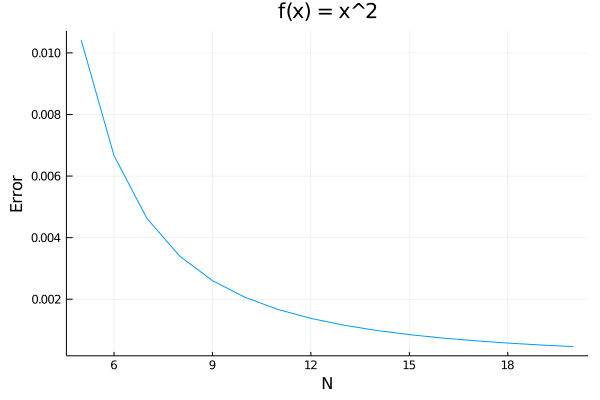

In [14]:
# Plot error function
axis = 5:1:20

plot(axis, [errors(f2, x_lower, x_upper, i) for i in axis],
     legend=false, xlabel="N", ylabel="Error", title="f(x) = x^2")

Note that the errors are decreasing in N.

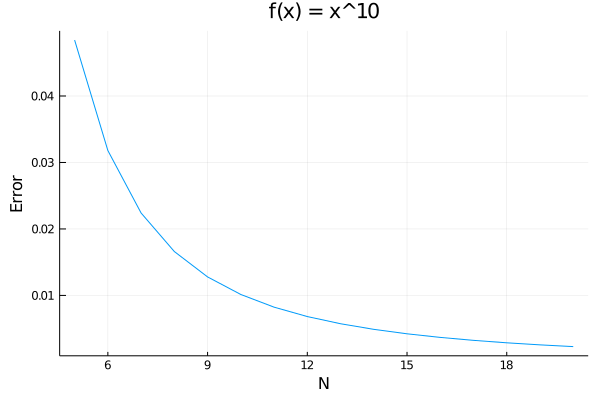

In [15]:
# Try another function
g(x) = x^10

plot(axis, [errors(g, x_lower, x_upper, i) for i in axis],
     legend=false, xlabel="N", ylabel="Error", title="f(x) = x^10")

Even with another function, the errors are decreasing in N.

In [20]:
# Test g(x) on the three cases:
x_lower = 0.0
x_upper = 1.0
x2 = x_lower:0.01:x_upper # AbstractRange (for type 2)

x1 = collect(x_lower:0.01:x_upper) # AbstractArray (for type 1)
h = x1.^10

# First case
@show trapezoidal(h,x1)

# Second case
h = x2.^10
@show trapezoidal(h,x2)

# Third case
x = 0.0:0.01:1.0
h2(x) = x.^10
N = 100
@show trapezoidal(h2, x_lower, x_upper, N)

trapezoidal(h, x1) = 0.0909924142434242
trapezoidal(h, x2) = 0.09099241424342419
trapezoidal(h2, x_lower, x_upper, N) = 0.09099410583750005


0.09099410583750005

Once again, the results do not differ much depending on the method of trapezoidal used.

In [21]:
# Check with different N
N2 = 200
@show trapezoidal(h2, x_lower, x_upper, N)
@show trapezoidal(h2, x_lower, x_upper, N2)

trapezoidal(h2, x_lower, x_upper, N) = 0.09099410583750005
trapezoidal(h2, x_lower, x_upper, N2) = 0.09093013351109802


0.09093013351109802

The result holds even by increasing N, with some differences at the decimal point likely due to rounding.

------
### Exercise 6 - Introduction to Types
Take a variation of your code in Exercise 5.
Use auto-differentiation to calculate the following derivative
$$
\frac{d}{d {\bar{x}}}\int_{\underline{x}}^{\bar{x}} f(x) \, dx
$$

In [22]:
using ForwardDiff

In [32]:
x = 0.0:0.01:1.0
f2(x) = x.^2
x_lower = 0.0
N = 100
b = 0.5

@show trapezoidal(f2, x_lower, b,  N)
@show trapezoidal(f2, x_lower, b+0.1,  N)

Derf2(x) = ForwardDiff.derivative(y -> trapezoidal(f2,x_lower,y,N), x)

@show Derf2(b)
@show Derf2(b+0.1)

trapezoidal(f2, x_lower, b, N) = 0.04166879230010544
trapezoidal(f2, x_lower, b + 0.1, N) = 0.07200367309458218
Derf2(b) = 0.25001275380063265
Derf2(b + 0.1) = 0.36001836547291094


0.36001836547291094